In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
from pathlib import Path

DPI = 300
FONTSIZE = 20  # 42
sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)

In [2]:
gene_sign = "NFKB_regulon_combined"
receiver="ipEMT"
DIR2LOAD = Path("/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/nichenet/concat_withWu2022/nichenet_microenvall_celltypes/intersect_cellphonedb/")

In [3]:
FIG2SAVE = DIR2LOAD.joinpath(f"figures/final/{gene_sign}_{receiver}/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [4]:
# table containing final ligand receptor interactions 
lr_df = pd.read_csv(DIR2LOAD.joinpath(f"{gene_sign}{receiver}_final_LR.csv"),
                    sep=",",
                    header=0,
                   )
lr_df.shape

(155, 3)

In [5]:
lr_df.head(3)

,from,to,potential
0,ALCAM,ALCAM,0.168997
1,ANGPT1,ITGB1,0.644951
2,ANGPT2,ITGB1,0.166711


In [6]:
# create column interaction ligand-receptor
lr_df["interaction"] = lr_df["from"] + "_" + lr_df["to"]
lr_df

,from,to,potential,interaction
0,ALCAM,ALCAM,0.168997,ALCAM_ALCAM
1,ANGPT1,ITGB1,0.644951,ANGPT1_ITGB1
2,ANGPT2,ITGB1,0.166711,ANGPT2_ITGB1
3,ANXA1,EGFR,0.903599,ANXA1_EGFR
4,APOE,LDLR,1.266901,APOE_LDLR
...,...,...,...,...
150,VCAM1,ITGA9,1.020421,VCAM1_ITGA9
151,VCAM1,EZR,0.786983,VCAM1_EZR
152,VCAM1,MSN,0.751009,VCAM1_MSN
153,VEGFA,FLT1,1.647269,VEGFA_FLT1


### load raw scRNA-seq data 

In [7]:
# load raw scRNA-seq data 
SCRNA_FILE2LOAD = Path(f"/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2location/prepareInputRNA/Multiome_Che_Wu_CRC_LM_annotations_raw_no_cycling_TME.h5ad")
# ideally use new annotations with enivronment used in cellphonedb 
adata = sc.read_h5ad(SCRNA_FILE2LOAD)

In [8]:
### log normalise 
# keep raw
adata.layers["raw"] = adata.X.copy()  # preserve counts

# normalize + log1p
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
adata.layers["normalised"] = adata.X.copy()
sc.pp.log1p(adata)

adata.layers["log1p"] = adata.X.copy()

adata.raw = adata  # keep normalised log1p

### select sender cells and zscore that object 

In [9]:
if gene_sign == "AP1_regulon":
    senders = [
        "ECM CAF", "Myofibroblast", "Pericyte",
        "SPP1 Mac", "Neutrophil", "IL1B Mac", "NLRP3 Mac",]

if gene_sign == "NFKB_regulon":    
    senders = ["SPP1 Mac", "Neutrophil", "IL1B Mac", "NLRP3 Mac", 
               "ECM CAF", "Myofibroblast", 
               "CD8 Tex", "Treg"]
    
if gene_sign == "NFKB_regulon_combined":    
    senders = ["SPP1 Mac", "Neutrophil", "IL1B Mac", "NLRP3 Mac", 
               "ECM CAF", "Myofibroblast", 
               "CD8 Tex", "Treg"]


adata_sender = adata[adata.obs.Annotation_scVI_detailed.isin(senders)].copy()

In [10]:
### z score 
adata_zscore_sender = adata_sender.raw.to_adata().copy()
# scale and store results in layer for later plotting
adata_zscore_sender.layers['scaled'] = sc.pp.scale(adata_zscore_sender, copy=True).X
adata_zscore_sender.obs=adata_sender.obs

### select epithelial cancer states and zscore that object

In [11]:
# isolate epithelial only 
adata_epi = adata[adata.obs.Annotation_scVI == "Epithelial"].copy()
adata_epi.obs.Annotation_scVI_detailed.value_counts()

TA1                  4116
Hypoxia              2481
Stem (NOTUM high)    1933
Colonocyte           1913
Stem                 1400
Intermediate         1319
pEMT                  998
UPR                   759
ipEMT                 469
Goblet                323
TA2                   162
Enteroendocrine        71
Tuft                   65
Name: Annotation_scVI_detailed, dtype: int64

In [12]:
### z score 
adata_zscore_epi = adata_epi.raw.to_adata().copy()
# scale and store results in layer for later plotting
adata_zscore_epi.layers['scaled'] = sc.pp.scale(adata_zscore_epi, copy=True).X
adata_zscore_epi.obs=adata_epi.obs

In [13]:
# define cancer states we want to plot
cancerstates2plot = [
                  "Stem",
                  "Stem (NOTUM high)",
                  "TA1",
                  "Intermediate", 
                  "Hypoxia",
                  "pEMT",
                  "ipEMT"]

In [14]:
# only select cancer states we want to plot
adata_zscore_epi = adata_zscore_epi[adata_zscore_epi.obs.Annotation_scVI_detailed.isin(cancerstates2plot)].copy()

### append mean zscore to ligand-receptor table

In [15]:
# create tmp tme adata that just contains ligands as genes (has duplicates because following order of lr)
adata_tme2ligand = adata_zscore_sender[:, lr_df["from"]].copy()
adata_tme2ligand.shape

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(25864, 155)

In [16]:
zscore_tme = pd.DataFrame(columns=adata_tme2ligand.obs['Annotation_scVI_detailed'].cat.categories, 
                          index=lr_df["interaction"]) 

zscore_tme.head(3)

,CD8 Tex,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,SPP1 Mac,Treg
interaction,,,,,,,,
ALCAM_ALCAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANGPT1_ITGB1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANGPT2_ITGB1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# compute average z-score per cell type per gene
for celltype in adata_tme2ligand.obs.Annotation_scVI_detailed.cat.categories:
    zscore_tme.loc[:, celltype] = adata_tme2ligand[
        adata_tme2ligand.obs.Annotation_scVI_detailed.isin([celltype]), :].layers["scaled"].mean(axis=0).T
zscore_tme = zscore_tme.astype(float)

In [18]:
zscore_tme.head(5)

,CD8 Tex,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,SPP1 Mac,Treg
interaction,,,,,,,,
ALCAM_ALCAM,-0.299731,0.551774,0.581873,1.521815,-0.018698,-0.230117,0.957740,-0.284747
ANGPT1_ITGB1,-0.055912,2.056100,-0.026165,0.994980,-0.022942,0.021992,-0.043252,-0.050692
ANGPT2_ITGB1,-0.041203,2.164340,-0.071755,0.410785,-0.073648,-0.087464,0.035567,-0.052859
ANXA1_EGFR,0.405321,-0.490868,0.193825,-0.027511,0.452168,-0.666903,0.422599,-0.509692
APOE_LDLR,-0.386987,-0.112188,1.389081,-0.172401,-0.200154,-0.428840,1.263847,-0.256685


### do the same for the cancerr cell states 

In [19]:
# create tmp cancer state adata that just contains receptors as genes (has duplicates because following order of lr)
adata_epi2receptor = adata_zscore_epi[:, lr_df["to"]].copy()
adata_epi2receptor.shape

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(12716, 155)

In [20]:
zscore_epi = pd.DataFrame(columns=adata_epi2receptor.obs.Annotation_scVI_detailed.cat.categories,
                          index=lr_df["interaction"]
                         )
zscore_epi.head(5)

,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT
interaction,,,,,,,
ALCAM_ALCAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANGPT1_ITGB1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANGPT2_ITGB1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANXA1_EGFR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APOE_LDLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
for celltype in adata_epi2receptor.obs.Annotation_scVI_detailed.cat.categories:
    zscore_epi.loc[:, celltype] = adata_epi2receptor[
        adata_epi2receptor.obs.Annotation_scVI_detailed.isin([celltype]), :].layers["scaled"].mean(axis=0).T
zscore_epi = zscore_epi.astype(float)
zscore_epi.head(5)

,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT
interaction,,,,,,,
ALCAM_ALCAM,0.147911,0.055597,-0.297900,0.417871,-0.177580,-0.245287,0.435789
ANGPT1_ITGB1,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019
ANGPT2_ITGB1,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019
ANXA1_EGFR,0.026349,0.221319,-0.008100,-0.214795,-0.075118,0.275920,0.058559
APOE_LDLR,0.102477,0.640323,-0.440371,-0.159299,0.002519,0.763670,0.178806


### to select: create another column where we compute difference mean zscore ipEMT vs other cancer states (except pEMT as it is similr to ipEMT) and we will use this to filter the receptors 

In [22]:
cancerstate2exclude = ["ipEMT", "pEMT"]

In [23]:
zscore_epi.loc[:, "cancer_state_means"]  = adata_epi2receptor[~adata_epi2receptor.obs.Annotation_scVI_detailed.isin(cancerstate2exclude), :].layers["scaled"].mean(axis=0).T

In [24]:
zscore_epi

,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT,cancer_state_means
interaction,,,,,,,,
ALCAM_ALCAM,0.147911,0.055597,-0.297900,0.417871,-0.177580,-0.245287,0.435789,0.008896
ANGPT1_ITGB1,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421
ANGPT2_ITGB1,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421
ANXA1_EGFR,0.026349,0.221319,-0.008100,-0.214795,-0.075118,0.275920,0.058559,-0.033643
APOE_LDLR,0.102477,0.640323,-0.440371,-0.159299,0.002519,0.763670,0.178806,0.016422
...,...,...,...,...,...,...,...,...
VCAM1_ITGA9,-0.314508,-0.033281,0.612443,0.208926,-0.008262,-0.357915,-0.562754,0.035833
VCAM1_EZR,0.141525,0.752365,-0.390941,-0.259796,-0.148291,0.851885,0.480324,-0.028123
VCAM1_MSN,-0.007943,0.356754,-0.086673,-0.030111,0.024500,0.164715,-0.010658,0.033090


### merge these two dataframes and then merge with ligand receptor dataframe

In [25]:
zscore_lr = zscore_tme.merge(right=zscore_epi,
                             how="inner",
                             left_index=True,
                             right_index=True
                            )

In [26]:
zscore_lr.head(3)

,CD8 Tex,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,SPP1 Mac,Treg,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT,cancer_state_means
interaction,,,,,,,,,,,,,,,,
ALCAM_ALCAM,-0.299731,0.551774,0.581873,1.521815,-0.018698,-0.230117,0.957740,-0.284747,0.147911,0.055597,-0.297900,0.417871,-0.177580,-0.245287,0.435789,0.008896
ANGPT1_ITGB1,-0.055912,2.056100,-0.026165,0.994980,-0.022942,0.021992,-0.043252,-0.050692,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421
ANGPT2_ITGB1,-0.041203,2.164340,-0.071755,0.410785,-0.073648,-0.087464,0.035567,-0.052859,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421


In [27]:
lr_df = lr_df.merge(right=zscore_lr,
            how="inner",
            left_on="interaction",
            right_index=True
           ).set_index(keys="interaction").copy()

In [28]:
lr_df.head(5)

,from,to,potential,CD8 Tex,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,SPP1 Mac,Treg,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT,cancer_state_means
interaction,,,,,,,,,,,,,,,,,,,
ALCAM_ALCAM,ALCAM,ALCAM,0.168997,-0.299731,0.551774,0.581873,1.521815,-0.018698,-0.230117,0.957740,-0.284747,0.147911,0.055597,-0.297900,0.417871,-0.177580,-0.245287,0.435789,0.008896
ANGPT1_ITGB1,ANGPT1,ITGB1,0.644951,-0.055912,2.056100,-0.026165,0.994980,-0.022942,0.021992,-0.043252,-0.050692,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421
ANGPT2_ITGB1,ANGPT2,ITGB1,0.166711,-0.041203,2.164340,-0.071755,0.410785,-0.073648,-0.087464,0.035567,-0.052859,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421
ANXA1_EGFR,ANXA1,EGFR,0.903599,0.405321,-0.490868,0.193825,-0.027511,0.452168,-0.666903,0.422599,-0.509692,0.026349,0.221319,-0.008100,-0.214795,-0.075118,0.275920,0.058559,-0.033643
APOE_LDLR,APOE,LDLR,1.266901,-0.386987,-0.112188,1.389081,-0.172401,-0.200154,-0.428840,1.263847,-0.256685,0.102477,0.640323,-0.440371,-0.159299,0.002519,0.763670,0.178806,0.016422


### maybe create column difference between ipEMT aka receiver and means z-score of all cancer state and then sort interactions by ligand and then by difference zscore 

In [29]:
c2diff = "cancer_state_means" #"Stem" # which cancer state to do the difference with

In [30]:
lr_df["difference"] = lr_df[receiver]-lr_df[c2diff]

In [31]:
lr_df.head(5)

,from,to,potential,CD8 Tex,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,SPP1 Mac,Treg,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT,cancer_state_means,difference
interaction,,,,,,,,,,,,,,,,,,,,
ALCAM_ALCAM,ALCAM,ALCAM,0.168997,-0.299731,0.551774,0.581873,1.521815,-0.018698,-0.230117,0.957740,-0.284747,0.147911,0.055597,-0.297900,0.417871,-0.177580,-0.245287,0.435789,0.008896,-0.254183
ANGPT1_ITGB1,ANGPT1,ITGB1,0.644951,-0.055912,2.056100,-0.026165,0.994980,-0.022942,0.021992,-0.043252,-0.050692,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421,0.329019
ANGPT2_ITGB1,ANGPT2,ITGB1,0.166711,-0.041203,2.164340,-0.071755,0.410785,-0.073648,-0.087464,0.035567,-0.052859,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421,0.329019
ANXA1_EGFR,ANXA1,EGFR,0.903599,0.405321,-0.490868,0.193825,-0.027511,0.452168,-0.666903,0.422599,-0.509692,0.026349,0.221319,-0.008100,-0.214795,-0.075118,0.275920,0.058559,-0.033643,0.309563
APOE_LDLR,APOE,LDLR,1.266901,-0.386987,-0.112188,1.389081,-0.172401,-0.200154,-0.428840,1.263847,-0.256685,0.102477,0.640323,-0.440371,-0.159299,0.002519,0.763670,0.178806,0.016422,0.747248


In [32]:
### sort interactions by ligand and then by z-score value of ipEMT? aka receiver
lr_df.sort_values(by=["from", "difference"], ascending=[True, False], inplace=True)

In [33]:
lr_df.head(5)

,from,to,potential,CD8 Tex,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,SPP1 Mac,Treg,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT,cancer_state_means,difference
interaction,,,,,,,,,,,,,,,,,,,,
ALCAM_ALCAM,ALCAM,ALCAM,0.168997,-0.299731,0.551774,0.581873,1.521815,-0.018698,-0.230117,0.957740,-0.284747,0.147911,0.055597,-0.297900,0.417871,-0.177580,-0.245287,0.435789,0.008896,-0.254183
ANGPT1_ITGB1,ANGPT1,ITGB1,0.644951,-0.055912,2.056100,-0.026165,0.994980,-0.022942,0.021992,-0.043252,-0.050692,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421,0.329019
ANGPT2_ITGB1,ANGPT2,ITGB1,0.166711,-0.041203,2.164340,-0.071755,0.410785,-0.073648,-0.087464,0.035567,-0.052859,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421,0.329019
ANXA1_EGFR,ANXA1,EGFR,0.903599,0.405321,-0.490868,0.193825,-0.027511,0.452168,-0.666903,0.422599,-0.509692,0.026349,0.221319,-0.008100,-0.214795,-0.075118,0.275920,0.058559,-0.033643,0.309563
APOE_LDLR,APOE,LDLR,1.266901,-0.386987,-0.112188,1.389081,-0.172401,-0.200154,-0.428840,1.263847,-0.256685,0.102477,0.640323,-0.440371,-0.159299,0.002519,0.763670,0.178806,0.016422,0.747248


### if we just want to keep 1 receptor per interaction we can just drop duplicates based on ligand and select first as i is ordered by difference 

In [34]:
lr_df_one_receptor = lr_df.drop_duplicates(subset="from", keep="first").copy()
lr_df_one_receptor

,from,to,potential,CD8 Tex,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,SPP1 Mac,Treg,Hypoxia,Intermediate,Stem,Stem (NOTUM high),TA1,ipEMT,pEMT,cancer_state_means,difference
interaction,,,,,,,,,,,,,,,,,,,,
ALCAM_ALCAM,ALCAM,ALCAM,0.168997,-0.299731,0.551774,0.581873,1.521815,-0.018698,-0.230117,0.957740,-0.284747,0.147911,0.055597,-0.297900,0.417871,-0.177580,-0.245287,0.435789,0.008896,-0.254183
ANGPT1_ITGB1,ANGPT1,ITGB1,0.644951,-0.055912,2.056100,-0.026165,0.994980,-0.022942,0.021992,-0.043252,-0.050692,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421,0.329019
ANGPT2_ITGB1,ANGPT2,ITGB1,0.166711,-0.041203,2.164340,-0.071755,0.410785,-0.073648,-0.087464,0.035567,-0.052859,0.117259,0.146612,-0.000346,-0.016220,-0.143876,0.316598,0.383019,-0.012421,0.329019
ANXA1_EGFR,ANXA1,EGFR,0.903599,0.405321,-0.490868,0.193825,-0.027511,0.452168,-0.666903,0.422599,-0.509692,0.026349,0.221319,-0.008100,-0.214795,-0.075118,0.275920,0.058559,-0.033643,0.309563
APOE_LDLR,APOE,LDLR,1.266901,-0.386987,-0.112188,1.389081,-0.172401,-0.200154,-0.428840,1.263847,-0.256685,0.102477,0.640323,-0.440371,-0.159299,0.002519,0.763670,0.178806,0.016422,0.747248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TNFSF12_TNFRSF12A,TNFSF12,TNFRSF12A,1.078488,-0.021513,-0.247249,0.751879,-0.180068,0.091957,-0.332269,0.041534,0.059307,0.095115,0.325080,-0.205678,-0.076354,-0.014768,0.273414,0.304449,0.014974,0.258440
TNFSF4_TRAF2,TNFSF4,TRAF2,0.377026,0.462323,-0.077277,-0.193414,0.296592,-0.231325,-0.234388,-0.226950,-0.152218,0.035821,0.036317,-0.091471,-0.004829,0.060682,0.115845,-0.053743,0.022149,0.093695
VCAM1_EZR,VCAM1,EZR,0.786983,0.521892,0.286436,-0.208356,0.551359,-0.258939,-0.257077,-0.239912,-0.210187,0.141525,0.752365,-0.390941,-0.259796,-0.148291,0.851885,0.480324,-0.028123,0.880008


In [35]:
lr_df_one_receptor.shape

(63, 20)

### Save this 1 ligand-1 receptor interaction file

In [36]:
lr_df_one_receptor.to_csv(DIR2LOAD.joinpath(f"{gene_sign}{receiver}_final_LR_1Ligand_2_1Receptor.csv"),
                    sep=",",
                    header=True,
                    index=True
                   )

### compute average log normalised gene expression per ligand

In [37]:
# create tmp tme adata that just contains ligands as genes (has duplicates because following order of lr)
adata_tme_one_receptor = adata_sender[:, lr_df_one_receptor["from"]].copy()
adata_tme_one_receptor.shape

(25864, 63)

In [38]:
avg_tme = pd.DataFrame(columns=adata_tme_one_receptor.obs['Annotation_scVI_detailed'].cat.categories, 
                       index=lr_df_one_receptor["from"]) 

avg_tme.head(3)

,CD8 Tex,ECM CAF,IL1B Mac,Myofibroblast,NLRP3 Mac,Neutrophil,SPP1 Mac,Treg
from,,,,,,,,
ALCAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANGPT1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANGPT2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# compute average z-score per cell type per gene
for celltype in adata_tme_one_receptor.obs.Annotation_scVI_detailed.cat.categories:
    avg_tme.loc[:, celltype] = adata_tme_one_receptor[
        adata_tme_one_receptor.obs.Annotation_scVI_detailed.isin([celltype]), :].X.mean(axis=0).T
avg_tme = avg_tme.astype(float)

In [40]:
avg_tme.to_csv(DIR2LOAD.joinpath(f"{gene_sign}{receiver}_final_LR_1Ligand_average_geneexp.csv"),
                    sep=",",
                    header=True,
                    index=True
                   )

### create heatmapp and get linkages: this will help to cluster ligands so we don't need to manually give the order 

### ligands heatmap

--- with euclidean

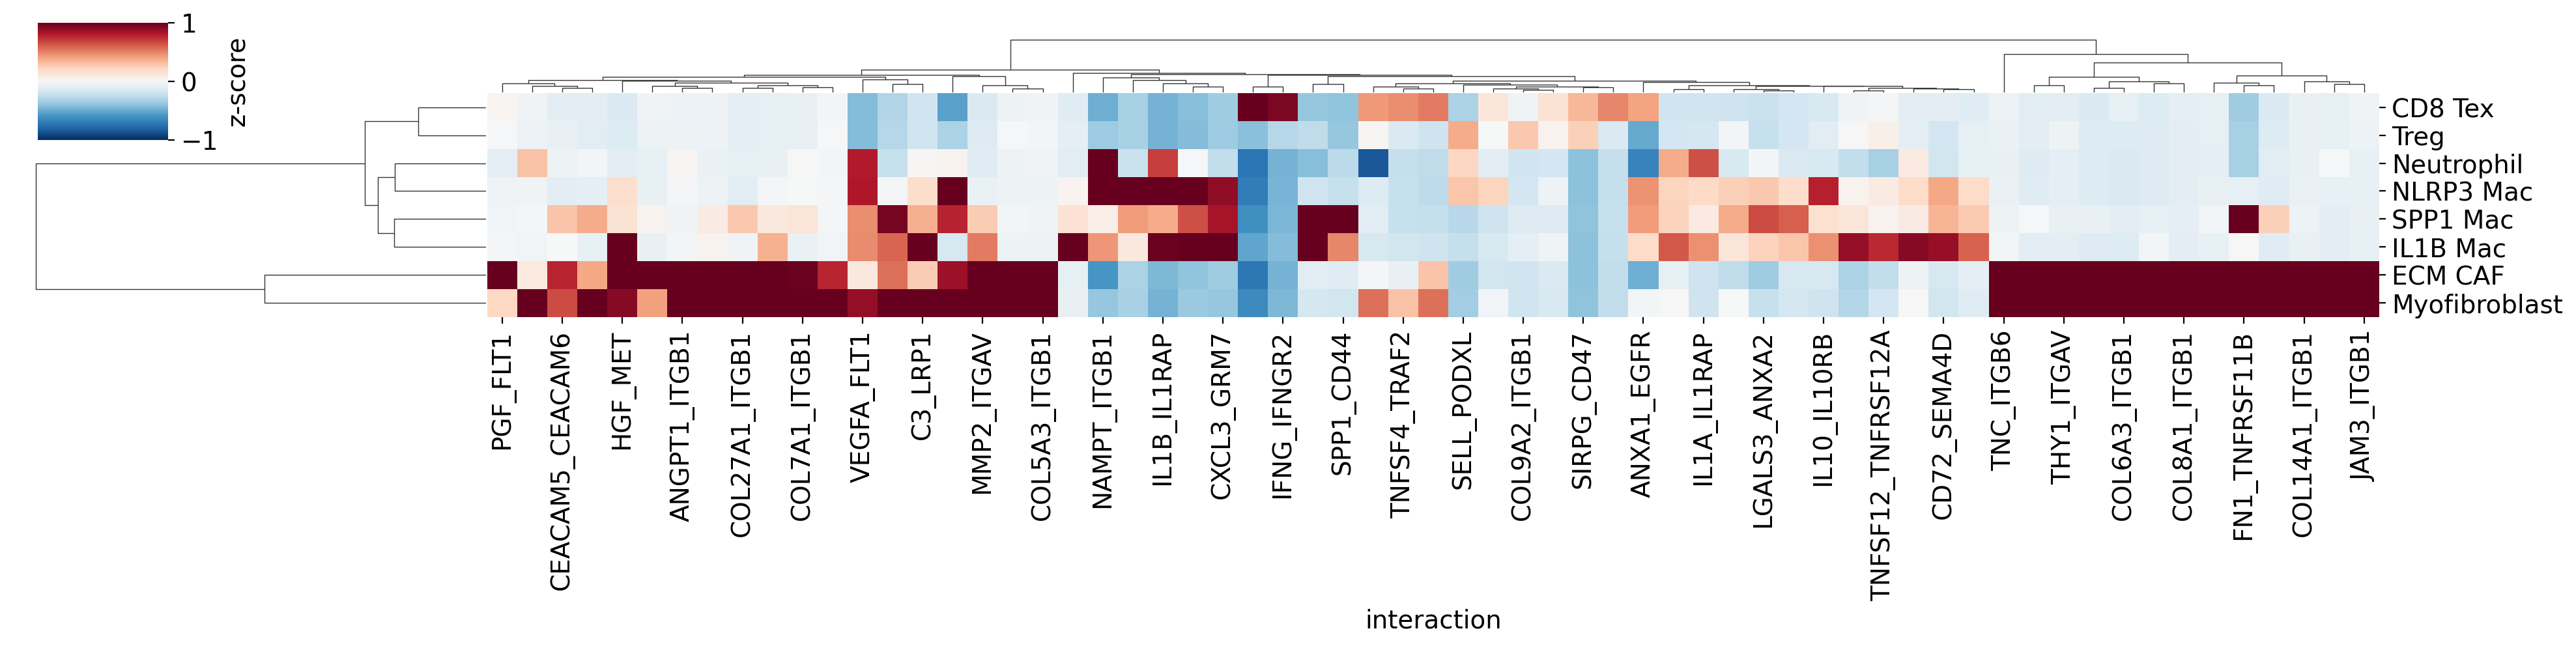

In [37]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
row_linkage, col_linkage = (hc.linkage(sp.distance.pdist(x, metric="euclidean"), method="average")
  for x in (lr_df_one_receptor[senders].values.T, lr_df_one_receptor[senders].values))

import seaborn as sns

g = sns.clustermap(lr_df_one_receptor[senders].T, row_linkage=row_linkage, col_linkage=col_linkage, vmin=-1,vmax=1,
                 figsize=(20,5),
                 cmap="RdBu_r", linecolor='black', cbar_kws={'label': 'z-score'})
#g.ax_cbar.set_position((0.15, 0.85, .03, .1))

--- with cosine

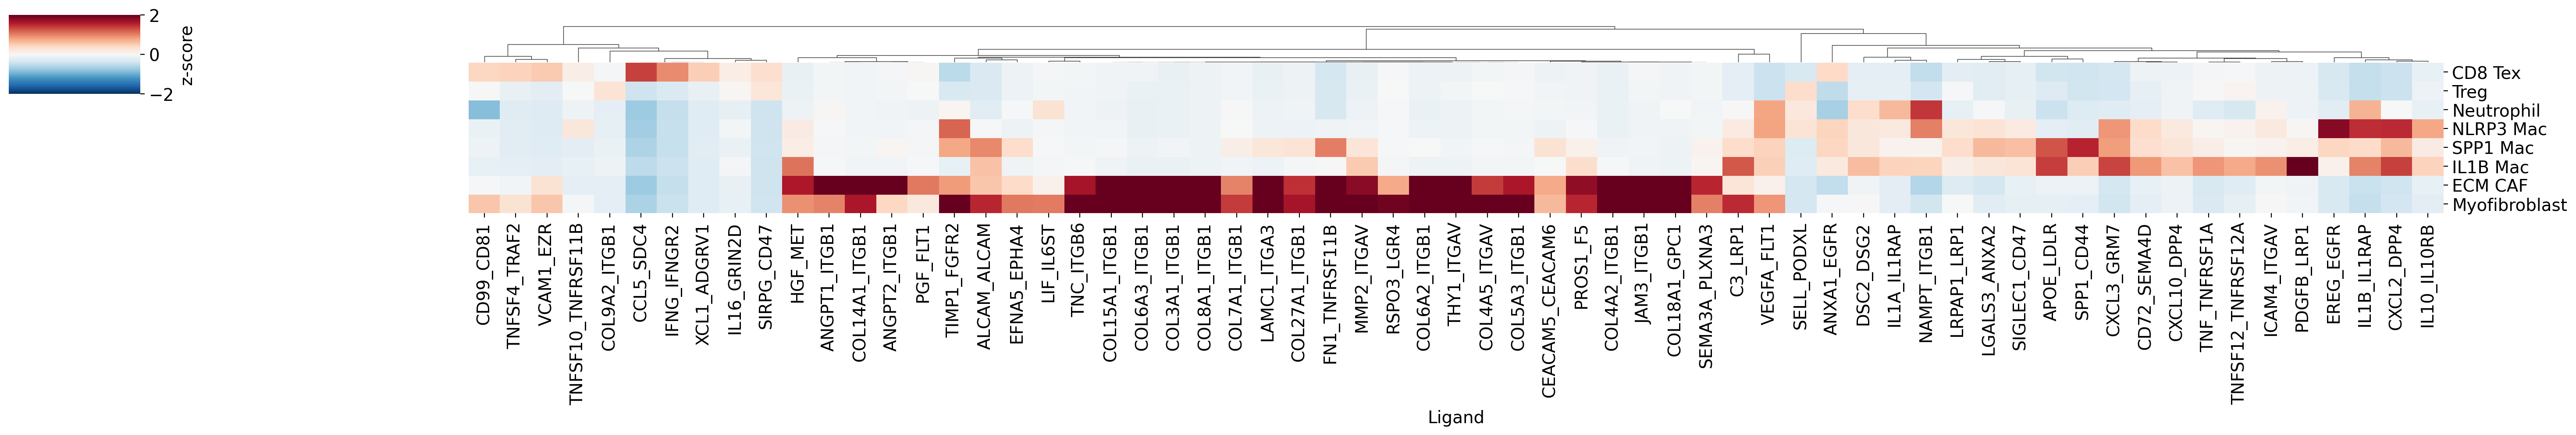

In [38]:
import matplotlib.pyplot as plt
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
row_linkage, col_linkage = (hc.linkage(sp.distance.pdist(x, metric="cosine"), method="average")
  for x in (lr_df_one_receptor[senders].values.T, lr_df_one_receptor[senders].values))

import seaborn as sns

g = sns.clustermap(lr_df_one_receptor[senders].T, row_linkage=None, col_linkage=col_linkage, vmin=-2,vmax=2, figsize=(30,5),
                 cmap="RdBu_r", linecolor='black', cbar_kws={'label': 'z-score'})
#g.ax_cbar.set_position((0.15, 0.85, .03, .1))
g.ax_heatmap.set_xlabel("Ligand")
g.ax_row_dendrogram.set_visible(False)
plt.savefig(FIG2SAVE.joinpath(f'{gene_sign}_{receiver}_zscore_senders_ligands.pdf'), dpi=DPI,
            format="pdf", bbox_inches="tight",)

In [39]:
# get order of ligands from the clustering
order_ligands = g.dendrogram_col.reordered_ind

In [40]:
# get order of celltypes of tme
order_tme = lr_df_one_receptor[senders].columns[g.dendrogram_row.reordered_ind].values

#### plot unique receptor ligand interaction for cancer states, 1 receptor

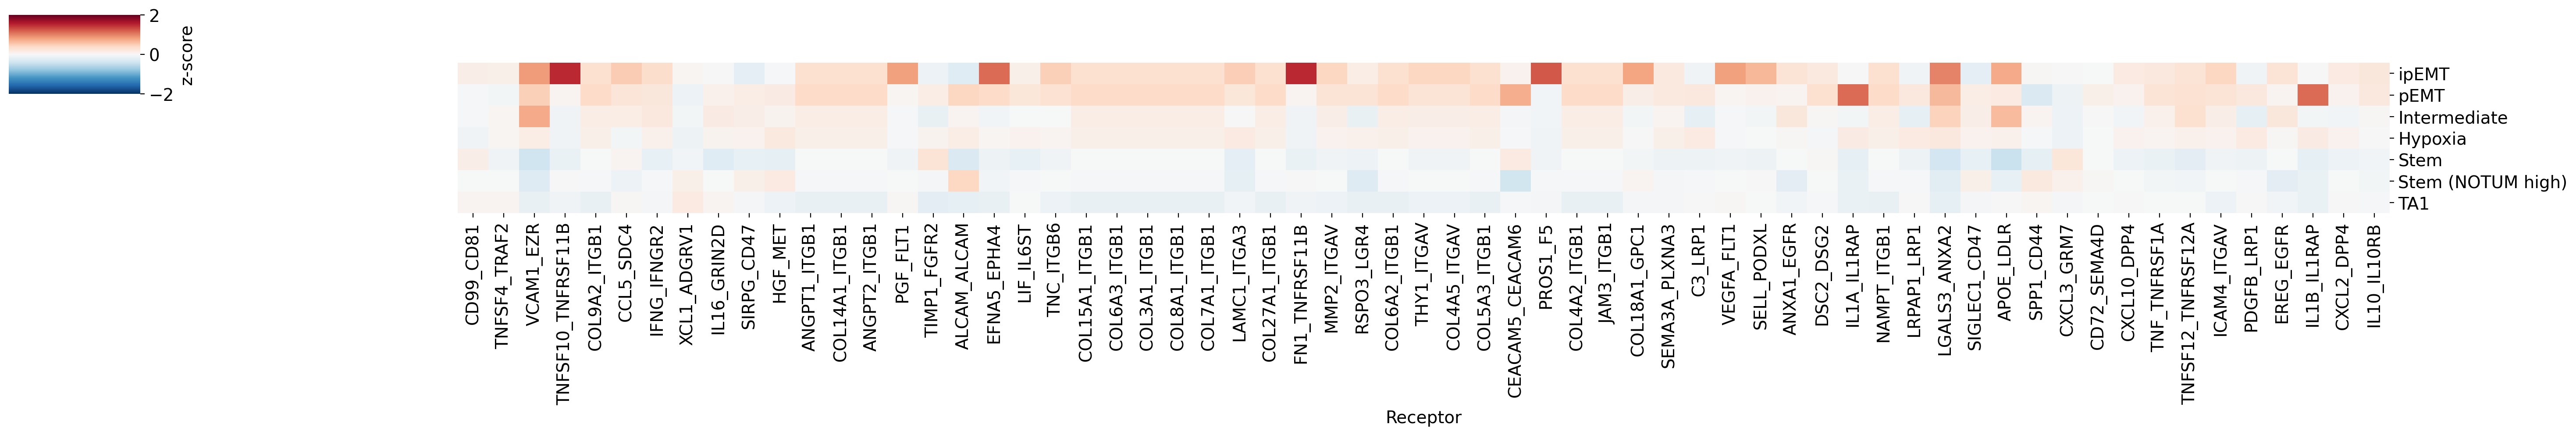

In [41]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
row_linkage_epi, col_linkage_epi = (hc.linkage(sp.distance.pdist(x, metric="euclidean"), method="average")
  for x in (lr_df_one_receptor[cancerstates2plot].values.T, lr_df_one_receptor[cancerstates2plot].values))

import seaborn as sns

g = sns.clustermap(lr_df_one_receptor[cancerstates2plot].T, row_linkage=row_linkage_epi, col_linkage=col_linkage, vmin=-2,vmax=2,
                 figsize=(30,5),
                 cmap="RdBu_r", linecolor='black', cbar_kws={'label': 'z-score'})
g.ax_heatmap.set_xlabel("Receptor")
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
plt.savefig(FIG2SAVE.joinpath(f'{gene_sign}_{receiver}_zscore_receptors.pdf'), dpi=DPI,
            format="pdf", bbox_inches="tight",)
#g.ax_cbar.set_position((0.15, 0.85, .03, .1))

In [42]:
# get order of celltypes of tme
order_receiver = lr_df_one_receptor[cancerstates2plot].columns[g.dendrogram_row.reordered_ind].values

### Plot ligand - gene target links heatmap

* sort ligand target df by order from clustermap of ligands above

In [43]:
n_ligands = len(lr_df["from"].unique())
vis_ligand_target = pd.read_csv(DIR2LOAD.joinpath(f"{gene_sign}{receiver}_nligands{n_ligands}_vis_ligand_target.csv"),
                                sep=",",
                                header=0,
                                index_col=0
                               )

In [44]:
gene_sign

'NFKB_regulon_combined'

In [45]:
vis_ligand_target.shape

(62, 59)

In [46]:
vis_ligand_target.index

Index(['PDGFB', 'VEGFA', 'IL10', 'LGALS3', 'EREG', 'RSPO3', 'EFNA5', 'LAMC1',
       'TNC', 'ICAM4', 'COL9A2', 'ANGPT2', 'CD72', 'COL7A1', 'PGF', 'APOE',
       'NAMPT', 'ANGPT1', 'COL15A1', 'IL16', 'COL8A1', 'COL4A2', 'CCL5',
       'SEMA3A', 'CEACAM5', 'LIF', 'LRPAP1', 'COL27A1', 'CXCL2', 'COL3A1',
       'CXCL3', 'COL5A3', 'COL4A5', 'COL14A1', 'ALCAM', 'TNFSF4', 'COL6A2',
       'SIGLEC1', 'THY1', 'COL18A1', 'MMP2', 'SELL', 'FN1', 'C3', 'JAM3',
       'XCL1', 'CD99', 'VCAM1', 'CXCL10', 'TIMP1', 'PROS1', 'SIRPG', 'IFNG',
       'HGF', 'COL6A3', 'SPP1', 'ANXA1', 'TNFSF10', 'TNFSF12', 'IL1A', 'IL1B',
       'TNF'],
      dtype='object')

In [47]:
# order ligands that were selected for ligand target heatmap
ligand2target_plot = [ele for ele in lr_df_one_receptor.iloc[order_ligands,:]["from"] if ele in vis_ligand_target.index]

In [48]:
# sort ligand target df by order from clustermap of ligands above
vis_ligand_target = vis_ligand_target.loc[ligand2target_plot,:].copy()

#### filter out some target genes by sum of potential

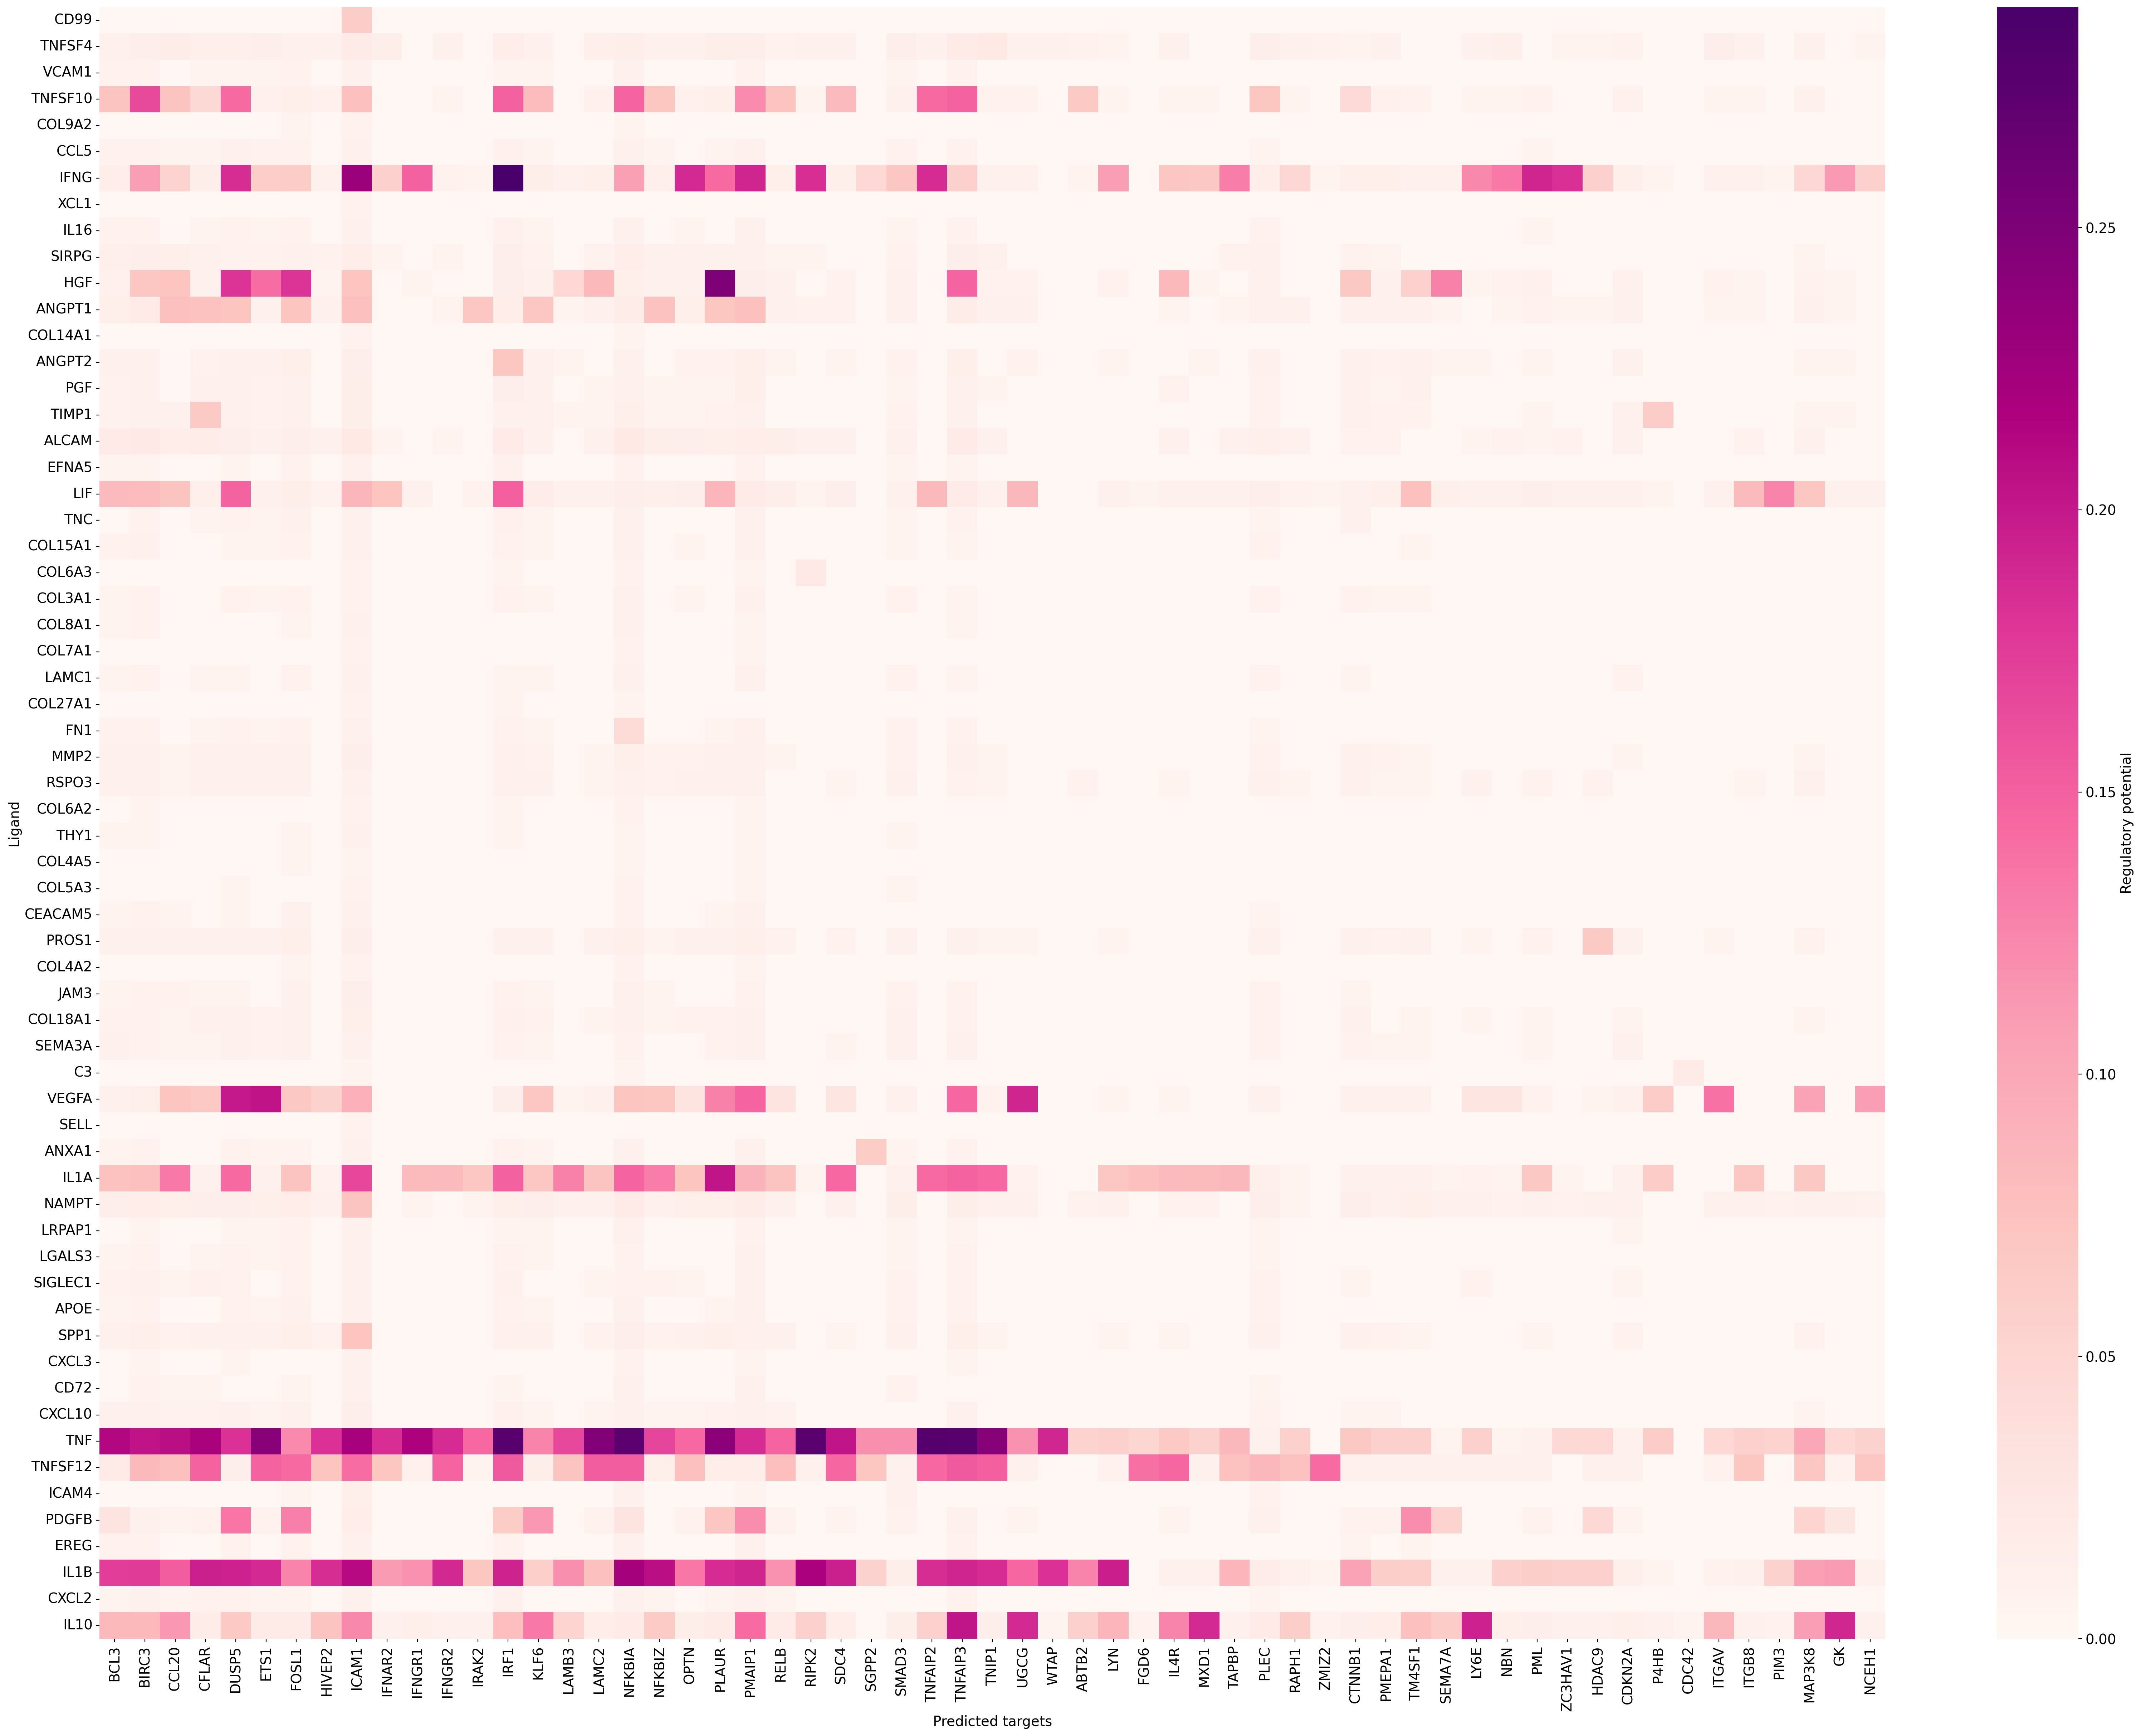

In [49]:
# set threshold TODO
threshold = 0
l_t_network2plot = vis_ligand_target.loc[:, vis_ligand_target.sum(axis=0)>threshold].copy()

plt.figure(figsize = (40,30))
ax = sns.heatmap(l_t_network2plot, cmap="RdPu", vmin=0, 
            cbar_kws={'label': 'Regulatory potential'},
           )
ax.set_xlabel("Predicted targets")
ax.set_ylabel("Ligand")
plt.savefig(FIG2SAVE.joinpath(f'{gene_sign}_{receiver}_ligand_target_regulatory_network.pdf'), dpi=DPI,
            format="pdf", bbox_inches="tight",)

### plot ligand expression across sender cells

In [50]:
# get order of ligands from clustering ligands 
ligands2plot = lr_df_one_receptor.iloc[order_ligands,:]["from"]

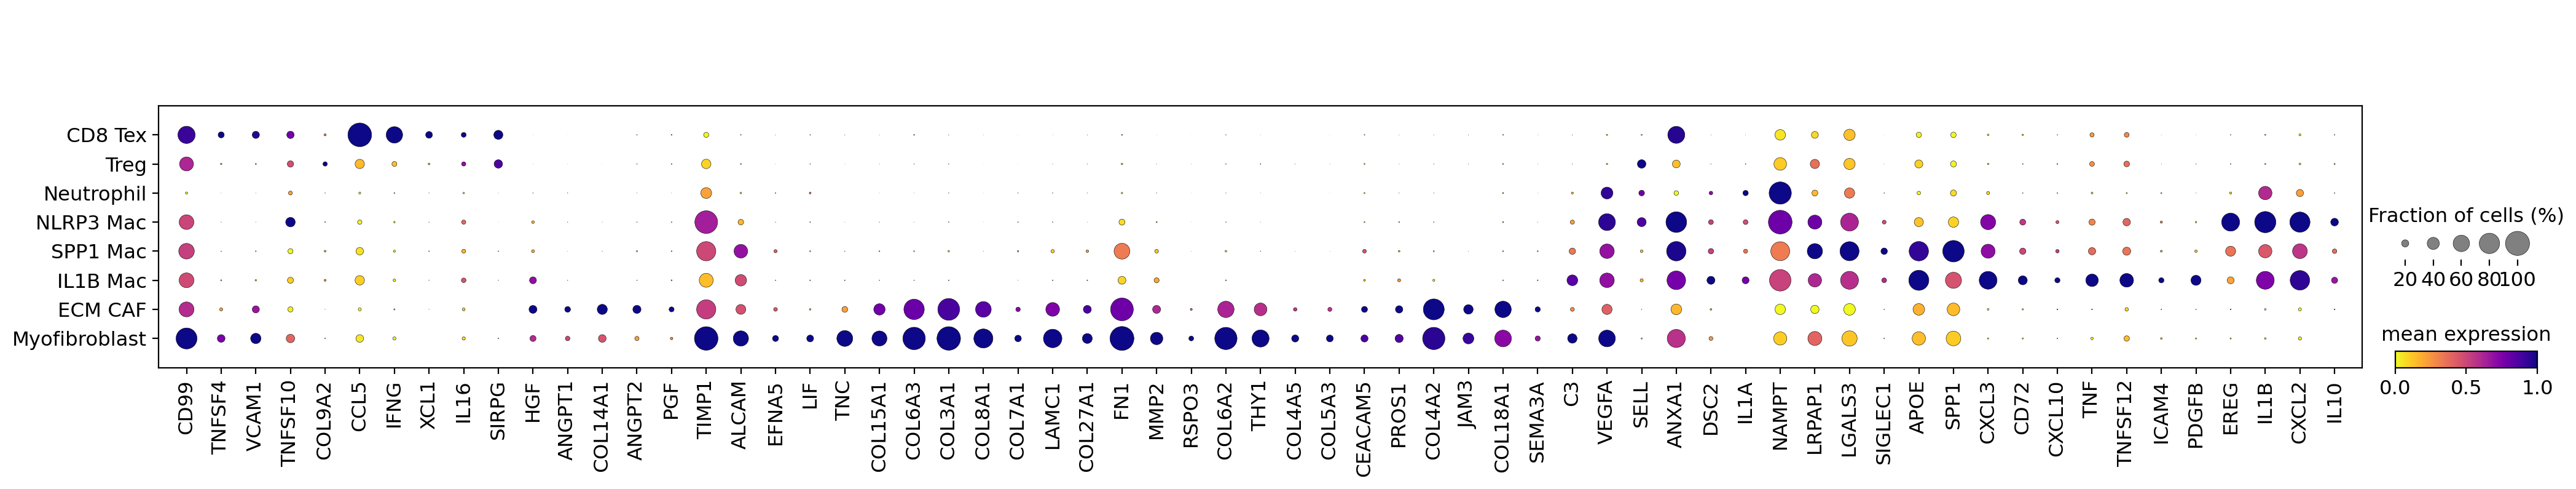

In [51]:
sc.pl.dotplot(adata=adata_sender, 
              var_names=ligands2plot,
              groupby="Annotation_scVI_detailed",
              categories_order=order_tme,
              cmap="plasma_r", #"coolwarm", 
              #layer="scaled", 
              vmin=0,
              vmax=1, 
              standard_scale="var",
              #dot_max=0.5, 
              colorbar_title = "mean expression", 
              size_title="Fraction of cells (%)",
              #save=f'{gene_sign}_{receiver}_zscore_senders_ligands_pre-filtering.pdf'
             )

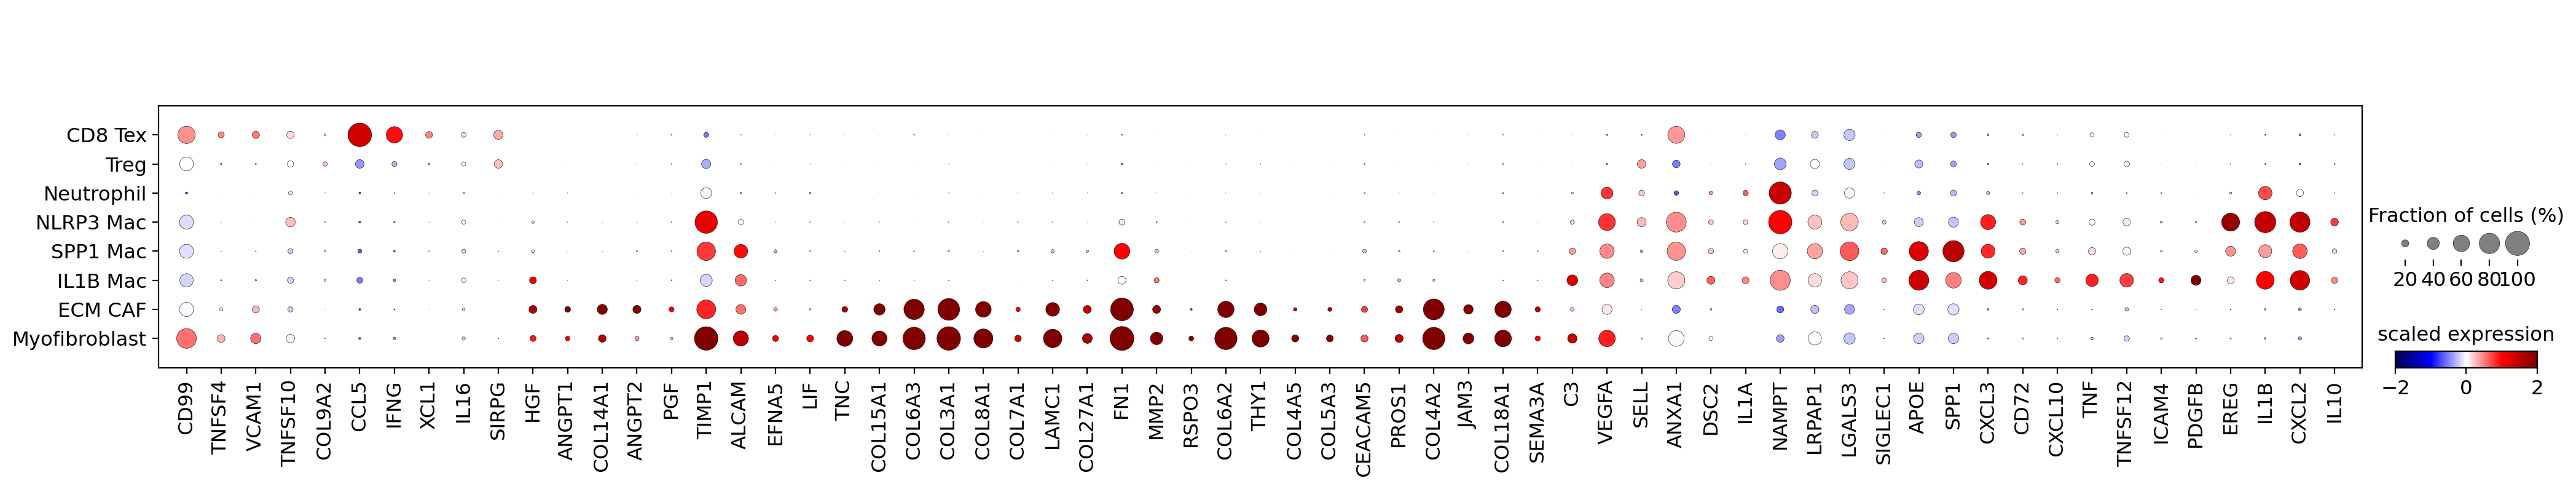

In [52]:
sc.pl.dotplot(adata=adata_zscore_sender, 
              var_names=ligands2plot,
              groupby="Annotation_scVI_detailed",
              categories_order=order_tme, #senders,
              cmap="seismic", #"coolwarm", 
              layer="scaled", 
              vmin=-2,
              vmax=2, 
              #dot_max=0.5, 
              colorbar_title = "scaled expression", 
              size_title="Fraction of cells (%)",
              save=f'{gene_sign}_{receiver}_zscore_senders_ligands.pdf'
             )

---

### plot receptor expression across cancer cells

In [53]:
# get order of receptors from clustering ligands 
receptors2plot = lr_df_one_receptor.iloc[order_ligands,:]["to"]

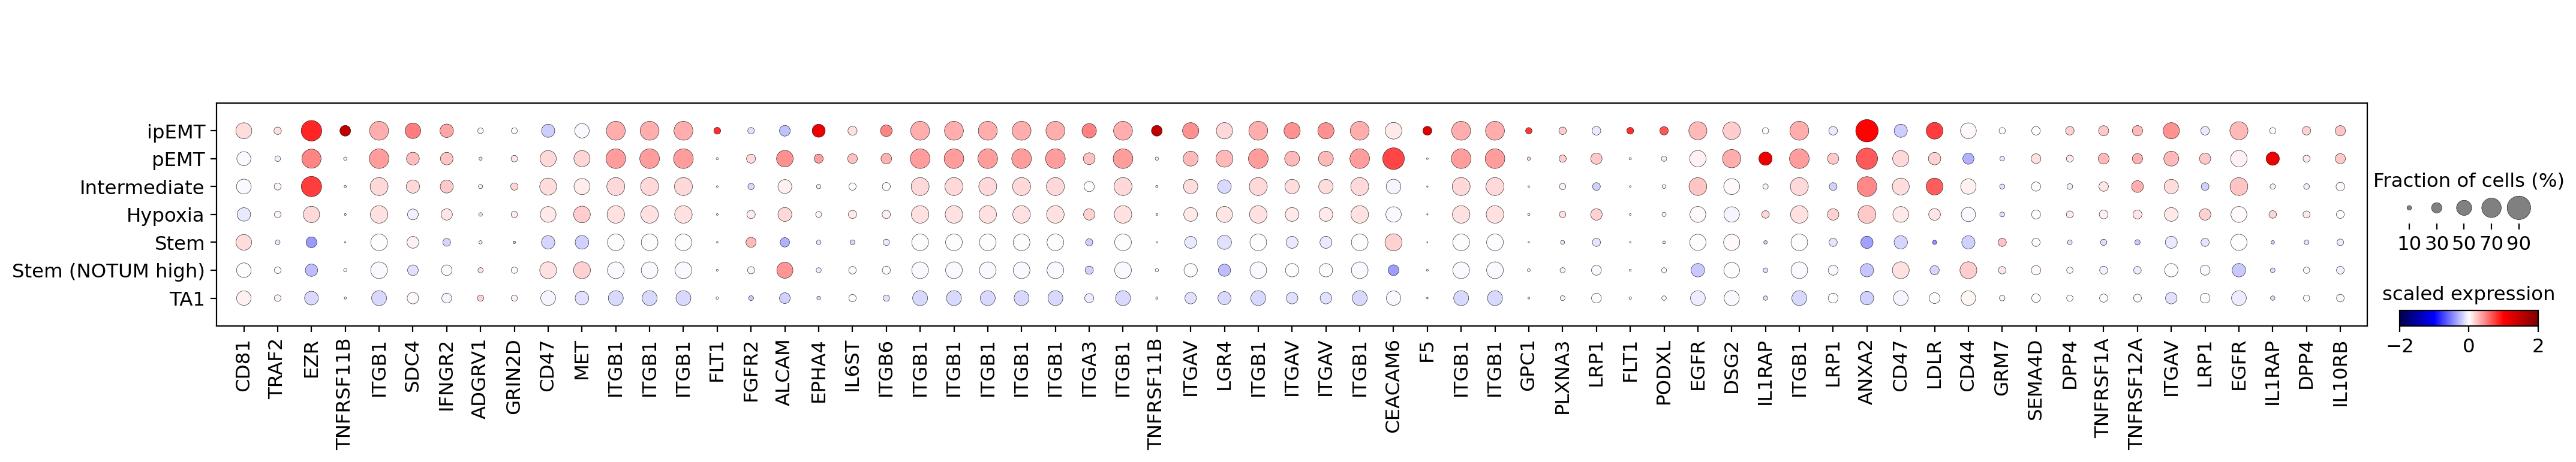

In [54]:
sc.pl.dotplot(adata=adata_zscore_epi, 
              var_names=receptors2plot,
              groupby="Annotation_scVI_detailed",
              categories_order=order_receiver,#cancerstates2plot,
              cmap="seismic", 
              layer="scaled", 
              vmin=-2,
              vmax=2, 
              #dot_max=0.5, 
              colorbar_title = "scaled expression", 
              size_title="Fraction of cells (%)",
              #save=f'{gene_sign}_{receiver}_zscore_cancercells_receptors_pre-filtering.pdf'
             )

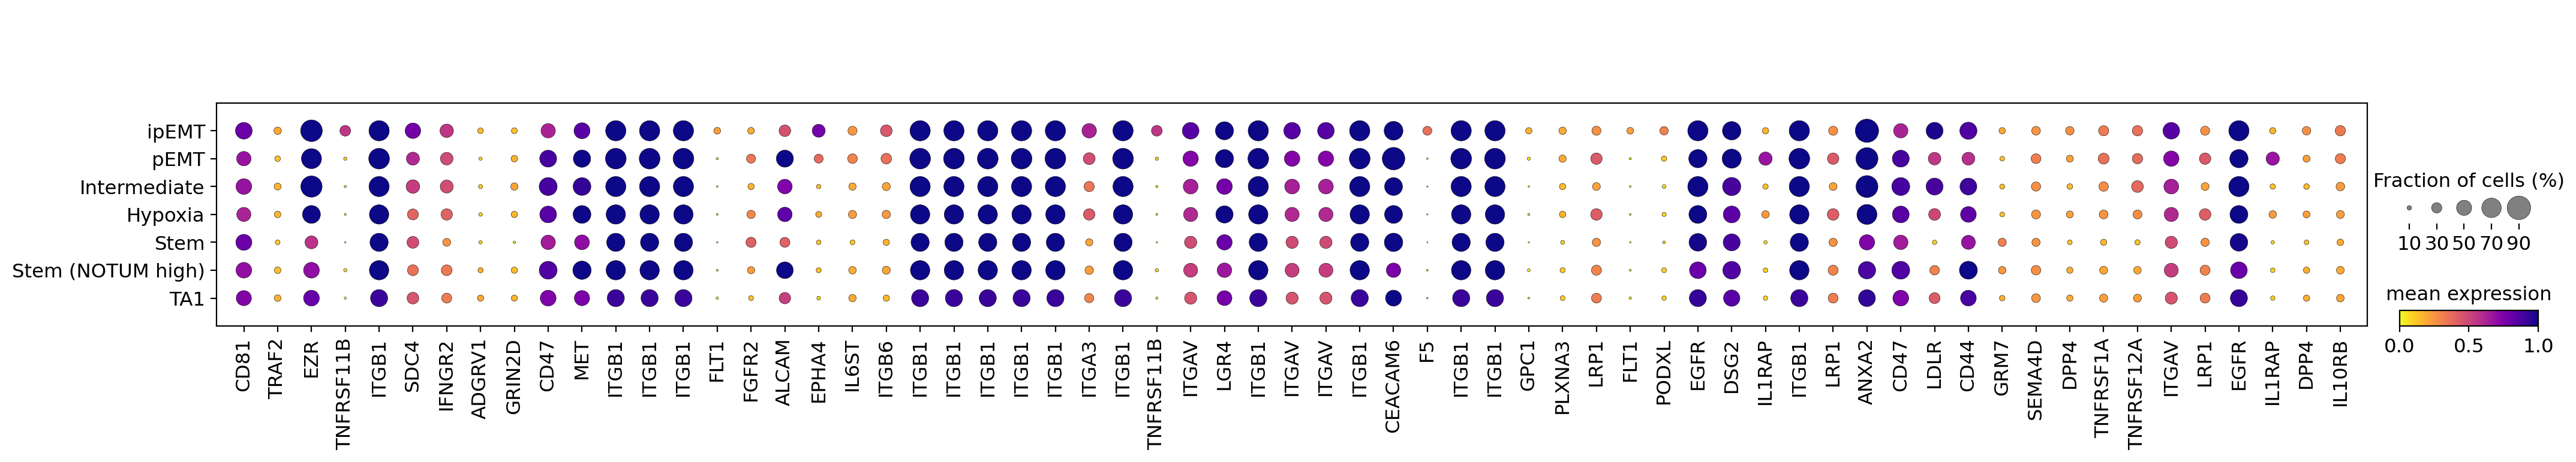

In [55]:
sc.pl.dotplot(adata=adata_epi[adata_epi.obs.Annotation_scVI_detailed.isin([
                  "Stem",
                  "Stem (NOTUM high)",
                  "TA1",
                  "Intermediate", 
                  "Hypoxia",
                  "pEMT",
                  "ipEMT"])], 
              var_names=receptors2plot,
              groupby="Annotation_scVI_detailed",
              categories_order=order_receiver,
              cmap="plasma_r", 
              layer="log1p", 
              vmin=0,
              vmax=1, 
              #standard_scale="var",
              #dot_max=0.5, 
              colorbar_title = "mean expression", 
              size_title="Fraction of cells (%)",
              #save=f'{gene_sign}_{receiver}_zscore_cancercells_receptors_pre-filtering.pdf'
             )

### if we plot all receptors (removing duplicates)

In [56]:
# get order of receptors from clustering ligands 
receptors_all = lr_df["to"].drop_duplicates()

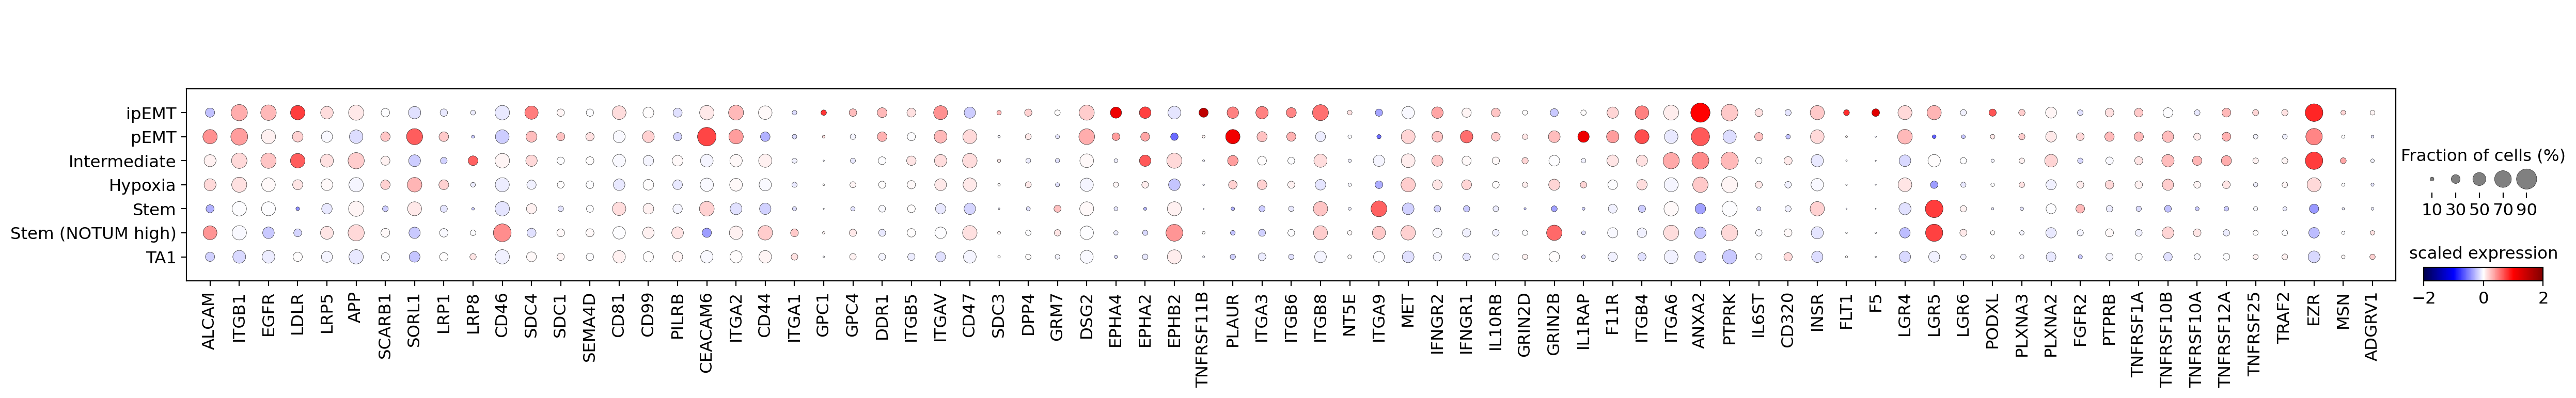

In [57]:
sc.pl.dotplot(adata=adata_zscore_epi, 
              var_names=receptors_all,
              groupby="Annotation_scVI_detailed",
              categories_order=order_receiver,
              cmap="seismic", 
              layer="scaled", 
              vmin=-2,
              vmax=2, 
              #dot_max=0.5, 
              colorbar_title = "scaled expression", 
              size_title="Fraction of cells (%)",
              save=f'{gene_sign}_{receiver}_zscore_cancercells_all_receptors_pre-filtering.pdf'
             )